# Image Classification using Deep Learning with SVM

### Udacity Machine Learning Engineer Nanodegree - Capstone Porject
### Student: Pavlos Sakoglou

### Final CNN-SVMC Model Training and Testing

=========================================================================================

As mentioned in the report file, after refining the model and adjusting the architecture, expect this model to do better than the initial one. This model is a regular CNN that uses a Support Vector Machine classifier at the penultimate layer instead of the sigmoid activation. Our goal is to compare this model with the final CNN model that uses the sigmoid. Below find the training process and results.

## 1. Import data and print data statistics

In [1]:
from sklearn.datasets import load_files      
from keras.utils import np_utils
from glob import glob
import numpy as np
import os

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    file_classes = np_utils.to_categorical(np.array(data['target']))
    return files, file_classes

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of class names
class_names = os.listdir("data/train")

# print statistics about the dataset
print('There are %d total classes:' % len(class_names))
print(class_names[0], class_names[1], "\n")
print('There are %s total images\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images' % len(train_files))
print('There are %d validation images' % len(valid_files))
print('There are %d test images'% len(test_files))

Using TensorFlow backend.


There are 2 total classes:
nude safe 

There are 13606 total images

There are 12302 training images
There are 467 validation images
There are 837 test images


## Convert the data into 244x244 dimensions of RGB values

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

### Helper functions

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

### Convert to RGB tensors

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print("Data are preprocessed!")

100%|████████████████████████████████████████| 837/837 [00:36<00:00, 22.67it/s]


Data are preprocessed!


# Refined network architecture

## Final CNN-SVMC model

In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras import regularizers

# CNN-SVMC model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation="linear", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

## Compile the final CNN-SVMC model

In [4]:
# CNN-SVMC
model.compile(loss='hinge', optimizer='rmsprop', metrics=['accuracy'])

## Train the CNN-SVMC model

#### Helper functions to plot training statistics

In [5]:
# helpers for training CNNs
import keras
import timeit
import matplotlib.pyplot as plt

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

#### Train the model

In [6]:
from keras.callbacks import ModelCheckpoint  

epochs = 20
batch_size = 16
epochtimer = EpochTimer()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.finalCNNSVMC.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_targets, 
                         validation_data=(valid_tensors, valid_targets),
                         epochs=epochs, batch_size=batch_size, verbose=0,
                         callbacks=[checkpointer, epochtimer])

Epoch 00000: val_loss improved from inf to 0.50000, saving model to saved_models/weights.best.finalCNNSVMC.hdf5
Epoch 0 took 1540.4891033717108 seconds
Epoch 00001: val_loss did not improve
Epoch 1 took 1246.09442604106 seconds
Epoch 00002: val_loss did not improve
Epoch 2 took 1233.881510286366 seconds
Epoch 00003: val_loss did not improve
Epoch 3 took 1226.6034512546944 seconds
Epoch 00004: val_loss did not improve
Epoch 4 took 1226.3455082199416 seconds
Epoch 00005: val_loss improved from 0.50000 to 0.50000, saving model to saved_models/weights.best.finalCNNSVMC.hdf5
Epoch 5 took 1235.6682143471126 seconds
Epoch 00006: val_loss did not improve
Epoch 6 took 1231.1793573042041 seconds
Epoch 00007: val_loss improved from 0.50000 to 0.50000, saving model to saved_models/weights.best.finalCNNSVMC.hdf5
Epoch 7 took 1266.1607620455216 seconds
Epoch 00008: val_loss did not improve
Epoch 8 took 1242.1475257212605 seconds
Epoch 00009: val_loss did not improve
Epoch 9 took 1233.498918462601 se

#### Plot results

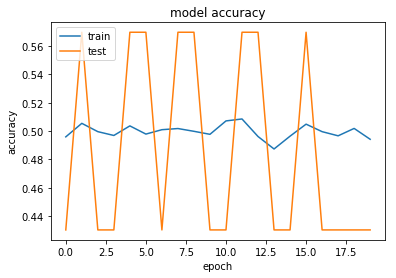

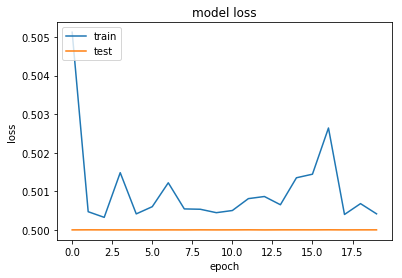

In [7]:
show_history_graph(hist)

## Test the final CNN-SVMC model

In [8]:
# Load optimal weights from the training
model.load_weights('saved_models/weights.best.finalCNNSVMC.hdf5')

# get index of prediction for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report on metrics

TP = 0  # true positives
TN = 0  # true negatives
FP = 0  # false positives
FN = 0  # false negatives

k = 0
for i in predictions:
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 1:
        TP = TP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 0:
        TN = TN + 1
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 0:
        FP = FP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 1:
        FN = FN + 1
        
    k = k + 1
    
### Accuracy
accuracy = 100 * (TP + TN) / len(predictions)

### Precision
precision = 100 * TP / (TP + FP)

### Recall
recall = 100 * TP / (TP + FN)

### F3-score
# Divide by 100 to scale the score back to [0, 1]
b = 3
fbscore = (1 / 100) * (1 + b*b) * precision * recall / (b * b * precision + recall)

### Print results
print("Test accuracy: %.4f%%" % accuracy)
print("Test Precision: %.4f%%" % precision)
print("Recall: %.4f%%" % recall)
print("F3-score: ",  fbscore)

Test accuracy: 51.4934%
Test Precision: 51.4934%
Recall: 100.0000%
F3-score:  0.9139100932994063


### Discussion

Intrestingly enough, when we replace the penultimate layer with the SVM classifier, the accuracy and precision drop drastically, and in fact perform worse than the arbitrary initial architecture and perform almost randomly -- like the benchmark. However, the recall and consequently the F3-score are improved dramatically. Although we care about the true positive rate in this application more than accuracy, having a very low accuracy and very low precision is not ideal. For further analysis see the Results section of the report